**Artificial Intelligence for Financial Portfolio Management: Reinforcement Learning with Q-Learning and LLM-Driven Sentiment Analysis**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 11691 sentiments.


<ipython-input-11-af6d5e0928a5>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_data['DATE'] = pd.to_datetime(matched_data['TIMESTAMP'], unit='ms', errors='coerce')
<ipython-input-11-af6d5e0928a5>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_data.dropna(subset=['DATE'], inplace=True)
[*********************100%***********************]  1 of 1 completed


Date range for stock data: 2014-03-10 16:52:50.698000 to 2014-08-28 12:10:37.092000
Episode 1/500, Portfolio Value: 11754.38, Total Reward: 7.27, Steps: 119
Episode 2/500, Portfolio Value: 10662.12, Total Reward: 7.73, Steps: 119
Episode 3/500, Portfolio Value: 10277.81, Total Reward: 5.61, Steps: 119
Episode 4/500, Portfolio Value: 10091.32, Total Reward: 7.24, Steps: 119
Episode 5/500, Portfolio Value: 10042.48, Total Reward: 7.72, Steps: 119
Episode 6/500, Portfolio Value: 10942.04, Total Reward: 7.99, Steps: 119
Episode 7/500, Portfolio Value: 10905.36, Total Reward: 8.41, Steps: 119
Episode 8/500, Portfolio Value: 10798.86, Total Reward: 8.78, Steps: 119
Episode 9/500, Portfolio Value: 11216.90, Total Reward: 10.70, Steps: 119
Episode 10/500, Portfolio Value: 10476.48, Total Reward: 7.20, Steps: 119
Episode 11/500, Portfolio Value: 11200.54, Total Reward: 7.53, Steps: 119
Episode 12/500, Portfolio Value: 10319.77, Total Reward: 6.52, Steps: 119
Episode 13/500, Portfolio Value: 114

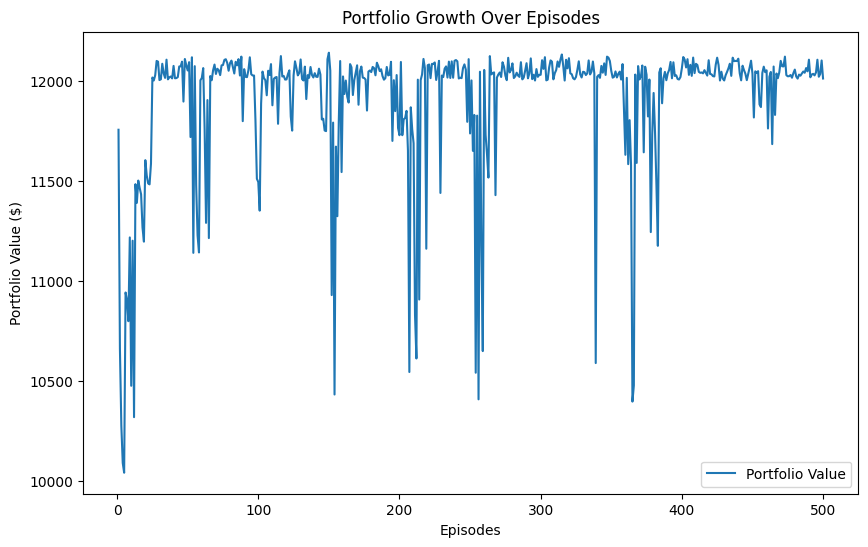

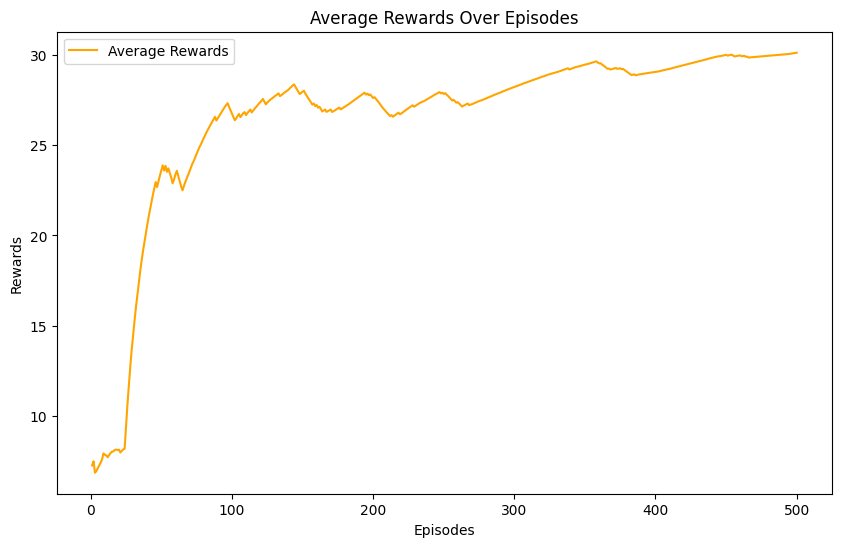

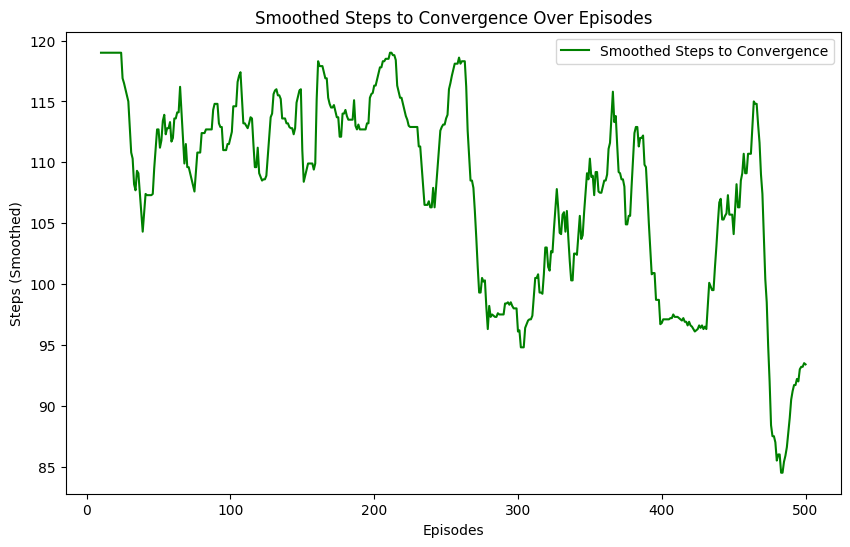

In [ ]:
# Install required libraries
!pip install numpy pandas matplotlib yfinance gym keras tensorflow scikit-learn textblob

from google.colab import drive
drive.mount('/content/drive')
# Required imports and setup
# Required imports and setup
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import gym
from gym import spaces
from collections import deque
import random
from textblob import TextBlob
import pandas as pd
import yfinance as yf

# Load Sentiments
def load_sentiments(sentiment_file_path):
    if os.path.exists(sentiment_file_path):
        with open(sentiment_file_path, "r") as file:
            sentiments = json.load(file)
    else:
        raise FileNotFoundError(f"{sentiment_file_path} does not exist.")
    print(f"Loaded {len(sentiments)} sentiments.")
    return sentiments

# Match Sentiments with Dates
def match_sentiments_with_dates(sentiments, csv_file_path):
    news_data = pd.read_csv(csv_file_path)
    matched_data = news_data[news_data['TITLE'].isin(sentiments.keys())]
    matched_data['DATE'] = pd.to_datetime(matched_data['TIMESTAMP'], unit='ms', errors='coerce')
    matched_data.dropna(subset=['DATE'], inplace=True)
    min_date = matched_data['DATE'].min()
    max_date = matched_data['DATE'].max()
    print(f"Date range for stock data: {min_date} to {max_date}")
    return min_date, max_date

# Portfolio Environment
class PortfolioEnv(gym.Env):
    def __init__(self, stock_data, initial_cash=10000, target_portfolio=12000):
        super().__init__()
        self.stock_data = stock_data
        self.initial_cash = initial_cash
        self.target_portfolio = target_portfolio
        self.current_step = None
        self.cash = None
        self.shares_held = None
        self.portfolio_value = None

        self.state_size = 5  # Close price, Cash, Shares held, Moving average, RSI
        self.action_size = 3  # Buy, Hold, Sell
        self.action_space = spaces.Discrete(self.action_size)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(self.state_size,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.cash = self.initial_cash
        self.shares_held = 0
        self.portfolio_value = self.initial_cash
        return self.get_state()

    def get_state(self):
        sma = self.stock_data["Close_AAPL"].rolling(window=5).mean().iloc[self.current_step]
        rsi = calculate_rsi(self.stock_data["Close_AAPL"], period=14).iloc[self.current_step]
        return np.array([
            float(self.stock_data.iloc[self.current_step]["Close_AAPL"]),
            float(self.cash),
            float(self.shares_held),
            float(sma) if not np.isnan(sma) else float(self.stock_data.iloc[self.current_step]["Close_AAPL"]),
            float(rsi) if not np.isnan(rsi) else 50.0
        ], dtype=np.float32)

    def step(self, action):
        current_price = float(self.stock_data.iloc[self.current_step]["Close_AAPL"])
        previous_value = self.portfolio_value

        if action == 0:  # Buy
            shares_to_buy = (self.cash * 0.1) // current_price
            self.cash -= shares_to_buy * current_price
            self.shares_held += shares_to_buy
        elif action == 2:  # Sell
            shares_to_sell = self.shares_held * 0.1
            self.cash += shares_to_sell * current_price
            self.shares_held -= shares_to_sell

        self.current_step += 1
        done = self.current_step >= len(self.stock_data) - 1
        self.portfolio_value = self.cash + self.shares_held * current_price

        reward = (self.portfolio_value - previous_value) / previous_value
        if action == 0 and self.portfolio_value > previous_value:  # Successful Buy
            reward += 0.2
        elif action == 2 and self.portfolio_value < previous_value:  # Successful Sell
            reward += 0.2
        else:
            reward -= 0.1

        # Adjust step penalty
        reward -= 0.1 * (self.current_step / len(self.stock_data))

        # Larger reward for early convergence
        if self.portfolio_value >= self.target_portfolio:
            reward += 30.0  # Larger bonus for reaching the target early
            done = True

        reward = max(reward, 0.01)
        return self.get_state(), reward, done

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# RL Agent
class RLAgent:
    def __init__(self, state_size, action_size, bins=20):
        self.state_size = state_size
        self.action_size = action_size
        self.bins = bins
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995  # Slower decay for better exploration early on
        self.epsilon_min = 0.05    # Allow minimal exploration
        self.learning_rate = 0.01
        self.q_table = np.zeros((bins,) * state_size + (action_size,))

    def discretize_state(self, state):
        state_scaled = state / np.max(state, axis=0)
        discretized = tuple(
            np.digitize(state_scaled[i], np.linspace(0, 1, self.bins)) - 1
            for i in range(self.state_size)
        )
        return discretized

    def act(self, state):
        discrete_state = self.discretize_state(state)
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.q_table[discrete_state])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            discrete_state = self.discretize_state(state)
            discrete_next_state = self.discretize_state(next_state)

            target = reward
            if not done:
                target += self.gamma * np.max(self.q_table[discrete_next_state])

            old_value = self.q_table[discrete_state + (action,)]
            self.q_table[discrete_state + (action,)] = old_value + self.learning_rate * (target - old_value)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Training RL Agent
def train_rl_agent(stock_data):
    env = PortfolioEnv(stock_data, initial_cash=10000, target_portfolio=12000)
    agent = RLAgent(state_size=env.state_size, action_size=env.action_size, bins=20)

    episodes = 500
    portfolio_values = []
    rewards = []
    steps_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        steps = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay(batch_size=64)
            state = next_state
            total_reward += reward
            steps += 1

        portfolio_values.append(env.portfolio_value)
        rewards.append(total_reward)
        steps_per_episode.append(steps)

        print(f"Episode {episode + 1}/{episodes}, Portfolio Value: {env.portfolio_value:.2f}, Total Reward: {total_reward:.2f}, Steps: {steps}")

    return portfolio_values, rewards, steps_per_episode

# Visualization with Smoothed Steps
def plot_metrics(portfolio_values, rewards, steps_per_episode):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(portfolio_values) + 1), portfolio_values, label="Portfolio Value")
    plt.title("Portfolio Growth Over Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    avg_rewards = [np.mean(rewards[:i+1]) for i in range(len(rewards))]
    plt.plot(range(1, len(avg_rewards) + 1), avg_rewards, label="Average Rewards", color="orange")
    plt.title("Average Rewards Over Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.legend()
    plt.show()

    # Smoothed Steps Visualization
    window_size = 10
    smoothed_steps = pd.Series(steps_per_episode).rolling(window=window_size).mean()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(smoothed_steps) + 1), smoothed_steps, label="Smoothed Steps to Convergence", color="green")
    plt.title("Smoothed Steps to Convergence Over Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Steps (Smoothed)")
    plt.legend()
    plt.show()

# Main Execution
if __name__ == "__main__":
    sentiment_file_path = "/content/drive/My Drive/sentiments2.json"
    csv_file_path = "/content/drive/My Drive/uci-news-aggregator.csv"

    sentiments = load_sentiments(sentiment_file_path)
    min_date, max_date = match_sentiments_with_dates(sentiments, csv_file_path)

    # Fetch stock data
    stock_data = yf.download("AAPL", start=min_date.strftime('%Y-%m-%d'), end=max_date.strftime('%Y-%m-%d'))

    # Handle MultiIndex columns
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = ['_'.join(col).strip() for col in stock_data.columns]

    # Ensure Close column exists
    if "Close_AAPL" not in stock_data.columns:
        raise KeyError("Close_AAPL column missing. Ensure stock data has correct format.")

    # Train the RL agent
    portfolio_values, rewards, steps_per_episode = train_rl_agent(stock_data)
    plot_metrics(portfolio_values, rewards, steps_per_episode)
